In [75]:
# # this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


# OLTraj Example 1: Plotting Lagrangian trajectories along a cruise track

## Objective
Given a ship track (in UTC_time, latitude and longitude), extract and plot trajectories (backward and forward) along the track. 

## Input data: 
Cruise track and corresponding OLTraj product.


## Code:

Import needed modules

In [76]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import pandas as pd

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


Read cruise track

In [77]:
## this input file shoud look like this (it's important to keep the same exact names for the column labels):
## (Note also that the DateTime field is in UTC)
# DateTime_UTC,Latitude_degreesN,Longitude_degreesE
# 2017-09-23  17:46,50.06083333,-3.343666667
# 2017-09-24  11:21,48.92683333,-7.6235
# 2017-09-25  03:57,47.269,-11.01
# 2017-09-25  12:04,46.68633333,-12.00016667
# ...

track = pd.read_csv("../Input/amt27_track.csv")
track['DateTime_UTC'] = pd.to_datetime(track['DateTime_UTC'])



Extract OLTraj trajectories corresponding to cruise track

In [79]:
#### convert longitude to -180,180 degs
def convLon(ds):
    import copy

    new_lon = ((ds['lon'].values + 180) % 360) - 180
    lon = np.append(new_lon[720:], new_lon[:720] )
    ds['lon'] = lon

    #### shift trajlon array
    tmp = copy.deepcopy(ds['trajlon'].values)
    tmp2 = np.append(tmp[:,:,720:], tmp[:,:,   :720], axis=2)
    ds['trajlon'][:,:,:] = tmp2

    #### shift trajlat array
    del tmp, tmp2
    tmp = copy.deepcopy(ds['trajlat'].values)
    tmp2 = np.append(tmp[:,:,720:], tmp[:,:,   :720], axis=2)
    ds['trajlat'][:,:,:] = tmp2

    return ds

In [88]:
# intialise arrays that will store the trajectories
trajlon = np.full((len(track), 59), np.nan)
trajlat = np.full((len(track), 59), np.nan)

dirOLTraj = '/data/datasets/Projects/OLTraj/From_AVISO/OLTraj/Processed/Lagrangian_traj/'
for ifn in range(len(track)):   
    fname = track['DateTime_UTC'][ifn].strftime('%Y/%Y%m%d') + '_oltraj_uv_global.nc'
    fn = glob.glob(dirOLTraj + fname)[0]

    # open OLTraj file
    dsAV = xr.open_dataset(fn)

    # convert longitude to to -180,180 degs
    dsAV = convLon(dsAV)

    # read OLTraj trajectories corresponding to curretn location of cruise track 
    tmp = dsAV.sel(lon=track['Longitude_degreesE'][ifn], lat=track['Latitude_degreesN'][ifn], method="nearest")

    # store trajectories for given date
    trajlon[ifn] = tmp['trajlon']
    trajlat[ifn] = tmp['trajlat']



Plot cruise track and Lagrangian trajectories at each station along the track

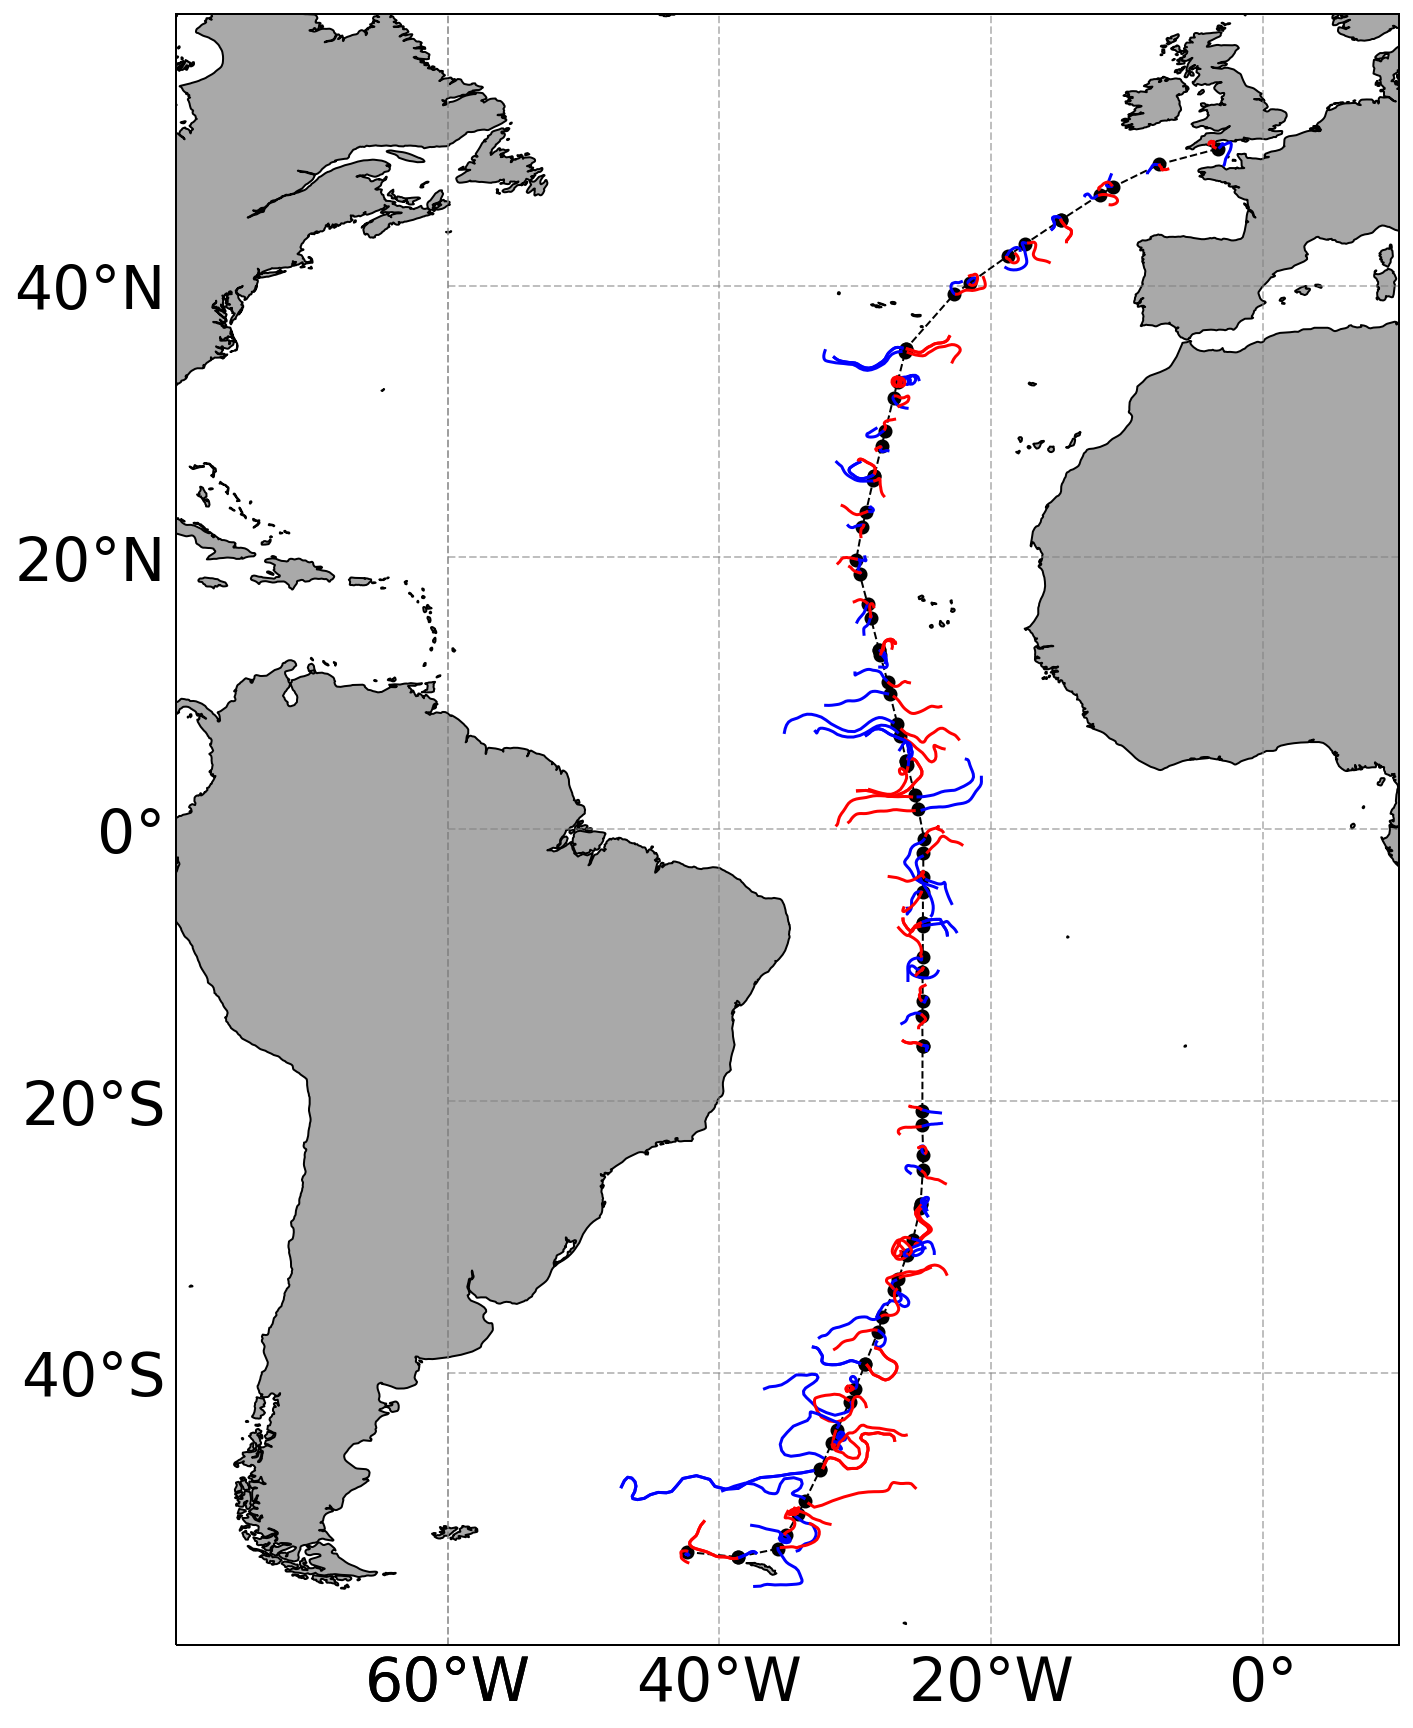

In [87]:
# initialise figure
fig = plt.figure(figsize=(40,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=-25) )

# plot cruise track
ax.plot(  track['Longitude_degreesE'], track['Latitude_degreesN'], transform=ccrs.PlateCarree(), lw=1, marker='o', color='k', ls='--' )

# plot Lagrangian trajectories
for it in range(len(trajlon)):
    # backward trajectories
    ax.plot(trajlon[it, :30], trajlat[it, :30], color='b', linestyle='-', transform=ccrs.PlateCarree() )
    # forward trajectories
    ax.plot(trajlon[it, 30:], trajlat[it, 30:], color='r', linestyle='-', transform=ccrs.PlateCarree() )

# add continents
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='darkgray'))

# set geographical extent of figure
ax.set_extent([-80, 10, -60, 60], ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-60, -60, -40, -20, 0, 10])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'fontsize': 30, 'color': 'k'}
gl.xlabel_style = {'fontsize': 30, 'color': 'k'}